In [24]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [25]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [26]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [27]:
%matplotlib inline

In [28]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(3579, 35)
(3579, 4)


# Multivariate Linear Regression (Foot prediction)

In [29]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [30]:
# Entries where FR is swinging
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_FR_swinging = X_motion[idxs]
Y_motion_FR_swinging = Y_motion[idxs]

## Predict FR foot -> x

In [31]:
X_motion_FR_swinging[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  2.64709865e-01,
        1.29830395e-01, -3.38858272e-01,  2.41059778e-01, -1.22873789e-01,
       -3.55994009e-01, -2.74628820e-01,  1.29782037e-01, -3.56233204e-01,
       -2.54233944e-01, -1.33633125e-01, -3.41321720e-01,  2.92673776e+01,
        2.23080942e-01,  3.83204199e-01, -1.10287466e-03,  1.40351884e-03,
        2.32242352e-03,  9.99995710e-01,  7.73709330e-02,  1.98805996e-03,
       -3.05314867e-02,  3.67494038e-02, -7.95687880e-02,  1.68014647e-03,
                   nan,             nan,  2.00000000e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00])

In [32]:
Y_motion_FR_swinging[0, :]

array([ 0.04414803, -0.00316722,  0.04134638,  0.00466252])

### Linear Regression

In [33]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # Previous motion command
               X_motion_FR_swinging[:, -5:-2], # Current motion command
               X_motion_FR_swinging[:, 3:5], # FL (x,y) position
               X_motion_FR_swinging[:, 6:8], # FR (x,y) position
               X_motion_FR_swinging[:, 9:11], # RL (x,y) position
               X_motion_FR_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9583429156099343
RMSE:  0.021481547190836777
The lowest error is:  2.6714204060751534e-05
The highest error is:  0.13072494112966887
The avg. error is:  0.014831559553609678


In [34]:
model_fr_relative_swinging_x.coef_

array([[ 2.93273694e-01, -1.40483312e+09,  2.26751219e+12,
         1.96469307e-01, -2.00413566e+09, -2.26751219e+12,
         1.69436187e+00,  1.61206178e+00, -8.83887827e-01,
        -9.17198107e-01,  1.53424576e-01,  8.51080611e-01,
        -2.78526413e+00, -1.85729951e+00]])

In [35]:
model_fr_relative_swinging_x.intercept_

array([-1.60397396])

Text(0, 0.5, 'Predictions')

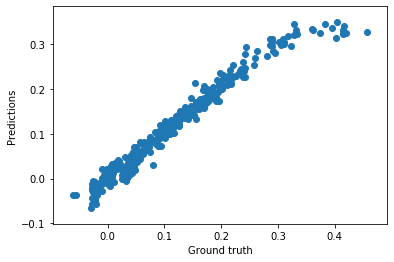

In [36]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [37]:
#%store model_fr_relative_swinging_x

In [38]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [39]:
# Save model
#joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

### Predict FL foot -> y

In [40]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # Previous motion command
               X_motion_FR_swinging[:, -5:-2], # Current motion command
               X_motion_FR_swinging[:, 3:5], # FL (x,y) position
               X_motion_FR_swinging[:, 6:8], # FR (x,y) position
               X_motion_FR_swinging[:, 9:11], # RL (x,y) position
               X_motion_FR_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9227699040210156
RMSE:  0.007171081186118588
The lowest error is:  6.2488820520845145e-06
The highest error is:  0.04301047768948968
The avg. error is:  0.0053207809012621055


In [41]:
model_fr_relative_swinging_y.coef_

array([[-1.04362134e-02, -3.29590006e+08,  5.31984436e+11,
         1.62805915e-02, -4.70193272e+08, -5.31984436e+11,
         5.82553089e-01,  2.46194430e-01, -7.35857189e-02,
         3.66420709e-02,  4.50676829e-02, -7.99261633e-01,
        -5.19630194e-01,  1.62783118e-01]])

In [42]:
model_fr_relative_swinging_y.intercept_

array([-0.15751274])

Text(0, 0.5, 'Predictions')

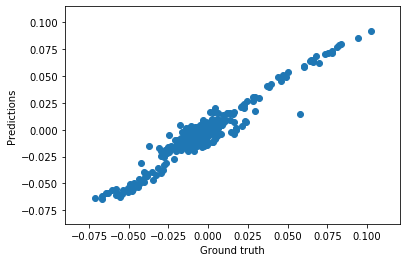

In [43]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [44]:
#%store model_fr_relative_swinging_y

In [45]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [23]:
# Save model
#joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")